# training model for [cultural classifier](https://cultural-classifier.herokuapp.com/)

# Our main task was to determine whether is possible to classify a archaeological cultures solely based on geographic data with the aid of ML techniques 

#### based on exploratory analysis we can say that viewshed, distance from the river and altitude above the river are most promising attributes for cultural classification



In [125]:
import pandas as pd
import numpy as np
import scipy as sp
import random 
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

#models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.model_selection import KFold, cross_val_score
import xgboost
#hyper parameter tuning
from sklearn.model_selection import GridSearchCV


# feature selection
from sklearn.feature_selection import SelectKBest
#compute anova
from sklearn.feature_selection import f_classif
#compute chi square
from sklearn.feature_selection import chi2

#metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

#saving model
import pickle

### preprocessed dataset - with all relavant attributes

### 0 is designated to EAU (eurrignacian)
### 1 is designated to EPIG (epiaurignacian)

In [4]:
df = pd.read_csv('C:/Users/hamro/Desktop/finished_projects/arch-heroku/data_used_for_training_model/preprocessed_final_table.csv')
df.head()

,Terrain variability 500 m buffer,Terrain variability 1000 m buffer,Elevation above river (m),DtR (m)cor,Viewshed,Classific
0,65,136,154,17400,197464,0
1,28,42,57,5430,22734,1
2,55,127,200,2300,204292,0
3,31,68,30,250,7675,1
4,21,72,15,80,2460,1


In [5]:
df['Classific'].value_counts()

1    26
0    15
Name: Classific, dtype: int64

### train - test split

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
len(df.columns)

6

### shuffle data - to prevent uneven data split

In [8]:
df = df.sample(frac=1).reset_index(drop=True)
df

,Terrain variability 500 m buffer,Terrain variability 1000 m buffer,Elevation above river (m),DtR (m)cor,Viewshed,Classific
0,67,122,124,17600,81239,0
1,57,107,152,22150,16236,1
2,65,136,154,17400,197464,0
3,28,42,29,1000,27123,1
4,38,79,22,300,1177,1
5,48,74,32,7700,18073,1
6,32,42,26,750,20919,1
7,28,72,20,140,5558,1
8,31,68,30,250,7675,1
9,68,134,33,60,215,1


In [9]:
X = df.loc[:, df.columns != 'Classific']
y = df.loc[:,'Classific']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=.3, random_state=42)

In [11]:
X_test.head()

,Terrain variability 500 m buffer,Terrain variability 1000 m buffer,Elevation above river (m),DtR (m)cor,Viewshed
24,83,172,201,12900,15828
13,62,132,31,40,218
8,31,68,30,250,7675
25,54,111,132,12700,149322
4,38,79,22,300,1177


In [12]:
X_test.columns

Index(['Terrain variability 500 m buffer', 'Terrain variability 1000 m buffer',
       'Elevation above river (m)', 'DtR (m)cor', 'Viewshed'],
      dtype='object')

## normalize data - scaling (0-1)

In [13]:
X_train_values = X_train.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled_train = min_max_scaler.fit_transform(X_train_values)

X_test_values = X_test.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled_test = min_max_scaler.fit_transform(X_test_values)


X_train = pd.DataFrame(x_scaled_train)
X_test = pd.DataFrame(x_scaled_test)


X_train.columns = ['Terrain variability 500 m buffer', 'Terrain variability 1000 m buffer','Elevation above river (m)', 
       'DtR (m)cor', 'Viewshed']
X_test.columns = ['Terrain variability 500 m buffer', 'Terrain variability 1000 m buffer','Elevation above river (m)', 
       'DtR (m)cor', 'Viewshed']


### our dataset is unbalanced and we do not have data

In [14]:
y_test.value_counts()

1    8
0    5
Name: Classific, dtype: int64

#### feature selection - only looking which features are the most important

In [15]:
#initialize the model
best_features = SelectKBest(score_func=f_classif, k = 'all')
fit = best_features.fit(X_train,y_train)

results = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

results_table = pd.concat([dfcolumns, results],axis=1)
results_table.columns = ['Features', 'Score']
results_table.sort_values(by='Score', ascending = False)

print(results_table.nlargest(7,'Score'))


                            Features      Score
3                         DtR (m)cor  19.629002
2          Elevation above river (m)  17.920333
4                           Viewshed  10.342960
1  Terrain variability 1000 m buffer   9.060405
0   Terrain variability 500 m buffer   4.327093


In [16]:
Y = y_train
X = X_train # independent columns
X.head()

#initialize the model
best_features = SelectKBest(score_func=chi2, k='all')
fit = best_features.fit(X,Y)

results = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

results_table = pd.concat([dfcolumns, results],axis=1)
results_table.columns = ['Features', 'Score']
results_table.sort_values(by='Score', ascending = False)

results_table.nlargest(6,'Score')

,Features,Score
3,DtR (m)cor,3.643314
4,Viewshed,2.677899
2,Elevation above river (m),2.239587
1,Terrain variability 1000 m buffer,1.250845
0,Terrain variability 500 m buffer,0.734742


In [17]:
# initialize model
model = ExtraTreesClassifier()
model.fit(X_train,y_train)

ExtraTreesClassifier()

In [18]:
model.feature_importances_

array([0.08351305, 0.17213502, 0.23985027, 0.33411644, 0.17038522])

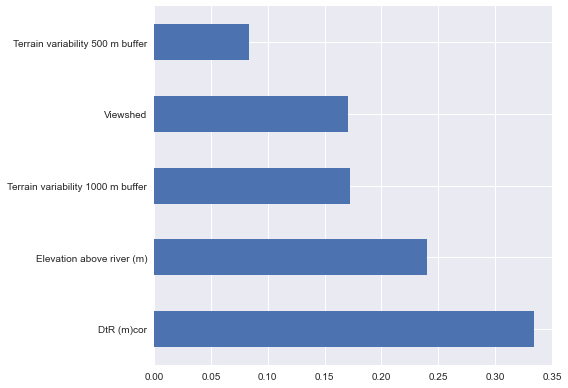

In [19]:
plt.style.use('seaborn')

feature_importance = pd.Series(model.feature_importances_, index = X.columns)
feature_importance.nlargest(7).plot(kind = 'barh')
plt.tight_layout()
plt.show()

<div style="background-color: orange; text-align:center; padding:5px;">
<h2>Modeling</h2>
</div>   

In [26]:
y_test.value_counts()

1    8
0    5
Name: Classific, dtype: int64

C:\Users\hamro\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:04:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:04:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:04:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


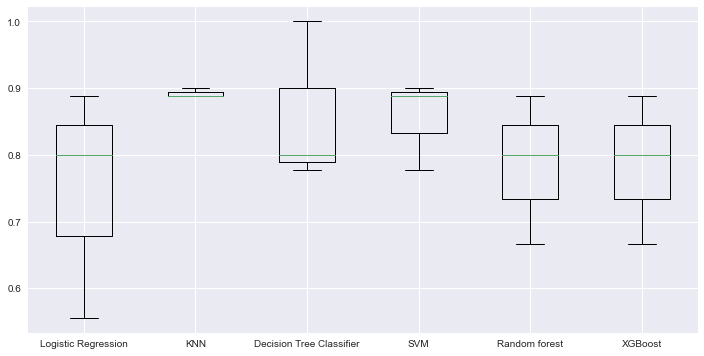

In [28]:
models = models = {"Logistic Regression": LogisticRegression(), "KNN": KNeighborsClassifier(), "Decision Tree Classifier": DecisionTreeClassifier(), "SVM": svm.SVC(), "Random forest": RandomForestClassifier(), "XGBoost":xgboost.XGBClassifier()}
results = []

for model in models.values():
    
    kf = KFold(n_splits=3, random_state=42, shuffle=True)
    cv = cross_val_score(model, X_train, y_train, cv=kf)
    results.append(cv)
    
plt.figure(figsize=(12, 6))
plt.boxplot(results, labels=models.keys())
plt.show()

### As we do not have much data, we're picking not complicated model - Logistic regression
### also we deal with an inbalanced dataset so we could upsample 0 class data using e.g. bootstrap but for the time being we're gonna use only current data
### models in gernal performed fairly similar

#### FINE-TUNING MODEL Logistic regression

In [131]:
params = {"penalty": ["l2"],
         "tol": np.linspace(0.0001, 1.0, 50),
         "C": np.linspace(0.1, 1.0, 50)}
kf = KFold(n_splits=3, random_state=42, shuffle=True)
LogReg = LogisticRegression()

LogReg_cv = GridSearchCV(LogReg, params, cv=kf)

LogReg_cv.fit(X_train, y_train)

print('Best parameter: {}'.format(LogReg_cv.best_params_))
print('Best score: {}'.format(LogReg_cv.best_score_))

Best parameter: {'C': 1.0, 'penalty': 'l2', 'tol': 0.4898469387755102}
Best score: 0.8555555555555555


### MODEL PREDICTIONS

In [132]:
LogReg = LogisticRegression(C=1, penalty='l2', tol=0.4898469387755102)

LogReg.fit(X_train, y_train)

predictions = LogReg.predict(X_test)

print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

              precision    recall  f1-score   support

           0       0.67      0.80      0.73         5
           1       0.86      0.75      0.80         8

    accuracy                           0.77        13
   macro avg       0.76      0.78      0.76        13
weighted avg       0.78      0.77      0.77        13

[[4 1]
 [2 6]]


### results

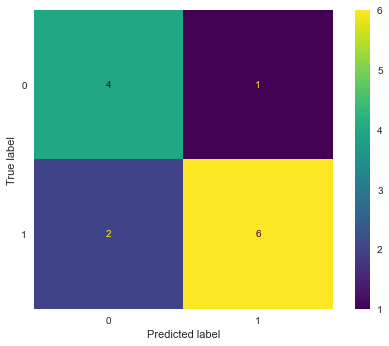

In [129]:
plot_confusion_matrix(LogReg_cv, X_test, y_test)
plt.grid(False)

In [133]:
r_probs = [0 for i in range(len(y_test))]
LogReg_probs = LogReg.predict_proba(X_test)
print(LogReg_probs)

LogReg_probs = LogReg_probs[:, 1]
print(LogReg_probs)

[[0.67120352 0.32879648]
 [0.14464038 0.85535962]
 [0.1167974  0.8832026 ]
 [0.72782441 0.27217559]
 [0.11441144 0.88558856]
 [0.65440489 0.34559511]
 [0.24504648 0.75495352]
 [0.51471095 0.48528905]
 [0.10507385 0.89492615]
 [0.12008882 0.87991118]
 [0.70899414 0.29100586]
 [0.10287992 0.89712008]
 [0.60871112 0.39128888]]
[0.32879648 0.85535962 0.8832026  0.27217559 0.88558856 0.34559511
 0.75495352 0.48528905 0.89492615 0.87991118 0.29100586 0.89712008
 0.39128888]


In [114]:
# calculate
LogReg_auc = roc_auc_score(y_test, LogReg_probs)
print("area under curve is: ", LogReg_auc)

area under curve is:  0.85


In [115]:
# calculate roc curve
LogReg_fpr, LogReg_tpr, _ = roc_curve(y_test, LogReg_probs)

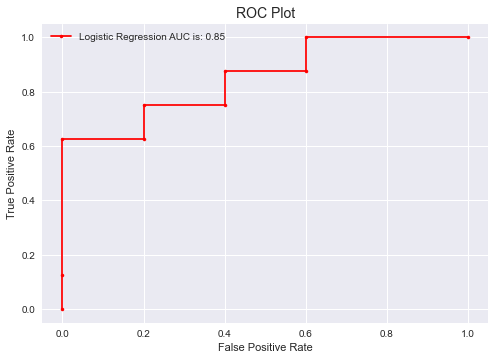

In [123]:
plt.plot(LogReg_fpr, LogReg_tpr, marker='.', label=f'Logistic Regression AUC is: {LogReg_auc}', color="red")
plt.title('ROC Plot', {'size':14})
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend() 
plt.show()

In [119]:
# save the model
# save the model to disk
filename = 'model.sav'
pickle.dump(LogReg, open(filename, 'wb'))